# Case Study - SABR and the Tariff Smile


## Introduction

A client buys a 1Y$\times$5Y **OTM payer swaption** (struck 100bp above ATM) from a dealer, seeking protection against a rate spike. The dealer delta-hedges the short position daily with the underlying 5Y swap.

We use the SABR model to analyze swaption smile dynamics during the `April 2025` tariff episode, calibrating to daily Bloomberg VCUB snapshots and testing the model’s ability to predict vol changes and improve hedging.

$$\Delta_{\text{SABR}} = \Delta_{\text{Black}} + \mathcal{V} \cdot \frac{\partial \sigma}{\partial F}$$


# Setup


In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
from cmds.volskew import sabr, sabrATM, solve_alpha

# Data

**Daily smile snapshots (April 2025):**
* `../data/swaption_smile_daily_2025.xlsx` — Bloomberg VCUB, 1Y$\times$5Y, Black vol (%) at strike offsets
  - Sheet `black_vol_pct`: rows = dates, columns = bp offsets from ATM
  - Sheet `atm_forward`: VCUB forward rates (%)
  - Sheet `absolute_strikes_pct`: computed absolute strikes (%)

**Time series (March–May 2025):**
* `../data/swaption_vol_timeseries_2025.xlsx` — daily ATM swaption Black vols
* `../data/sofr_swaps.xlsx` — daily SOFR swap rates


In [3]:
DATAPATH = '../data/'

# --- Daily smile snapshots (April 2025, 21 trading days) ---
smile_daily = pd.read_excel(DATAPATH + 'swaption_smile_daily_2025.xlsx',
                            sheet_name='black_vol_pct', index_col=0, parse_dates=True)
fwd_daily = pd.read_excel(DATAPATH + 'swaption_smile_daily_2025.xlsx',
                          sheet_name='atm_forward', index_col=0, parse_dates=True)

# --- Daily swap rates (pct -> decimal, March-May) ---
swaps_raw = pd.read_excel(DATAPATH + 'sofr_swaps.xlsx', sheet_name='data')
swaps_raw = swaps_raw.rename(columns={'Unnamed: 0': 'date'})
swaps_raw['date'] = pd.to_datetime(swaps_raw['date'])
swaps_raw = swaps_raw.set_index('date')
rate_5y = swaps_raw.loc['2025-03-01':'2025-05-31', 5.0] / 100

# --- Daily ATM swaption vols (bp, March-May) ---
vol_ts = pd.read_excel(DATAPATH + 'swaption_vol_timeseries_2025.xlsx',
                       sheet_name='atm_vols', index_col=0, parse_dates=True)
vol_1y5y = vol_ts.loc['2025-03-01':'2025-05-31', '1Yx5Y']

# Align broad time series
common_dates = rate_5y.index.intersection(vol_1y5y.index)
rate_5y = rate_5y.loc[common_dates]
vol_1y5y = vol_1y5y.loc[common_dates]

### Smile Snapshots

The daily smile data covers 21 trading days in April 2025. Below are a few representative curves showing the evolution before, during, and after the tariff shock.


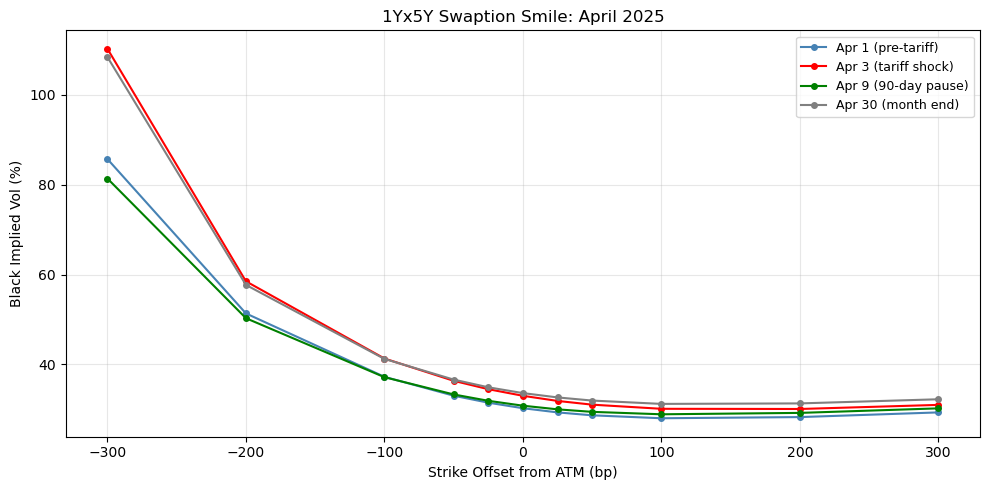

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

highlight_dates = ['2025-04-01', '2025-04-03', '2025-04-09', '2025-04-30']
colors = ['steelblue', 'red', 'green', 'gray']
labels = ['Apr 1 (pre-tariff)', 'Apr 3 (tariff shock)',
          'Apr 9 (90-day pause)', 'Apr 30 (month end)']

for dt_str, color, label in zip(highlight_dates, colors, labels):
    dt = pd.Timestamp(dt_str)
    if dt in smile_daily.index:
        offsets = smile_daily.columns.values.astype(int)
        vols = smile_daily.loc[dt].values
        ax.plot(offsets, vols, 'o-', color=color, label=label, markersize=4)

ax.set_xlabel('Strike Offset from ATM (bp)')
ax.set_ylabel('Black Implied Vol (%)')
ax.set_title('1Yx5Y Swaption Smile: April 2025')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Parameters


In [5]:
BETA = 0.5             # SABR beta
T_EXPIRY = 1.0         # 1Y option expiry
K_OFFSET = 0.01        # 100bp OTM payer
NOTIONAL = 100_000_000 # $100M notional
ANNUITY = 4.0          # approximate annuity factor
DOLLAR = NOTIONAL * ANNUITY
SHOCK = 1e-5           # finite-difference bump

CAL_OFFSETS = [-200, -100, -50, -25, 0, 25, 50, 100, 200]

### Market Context


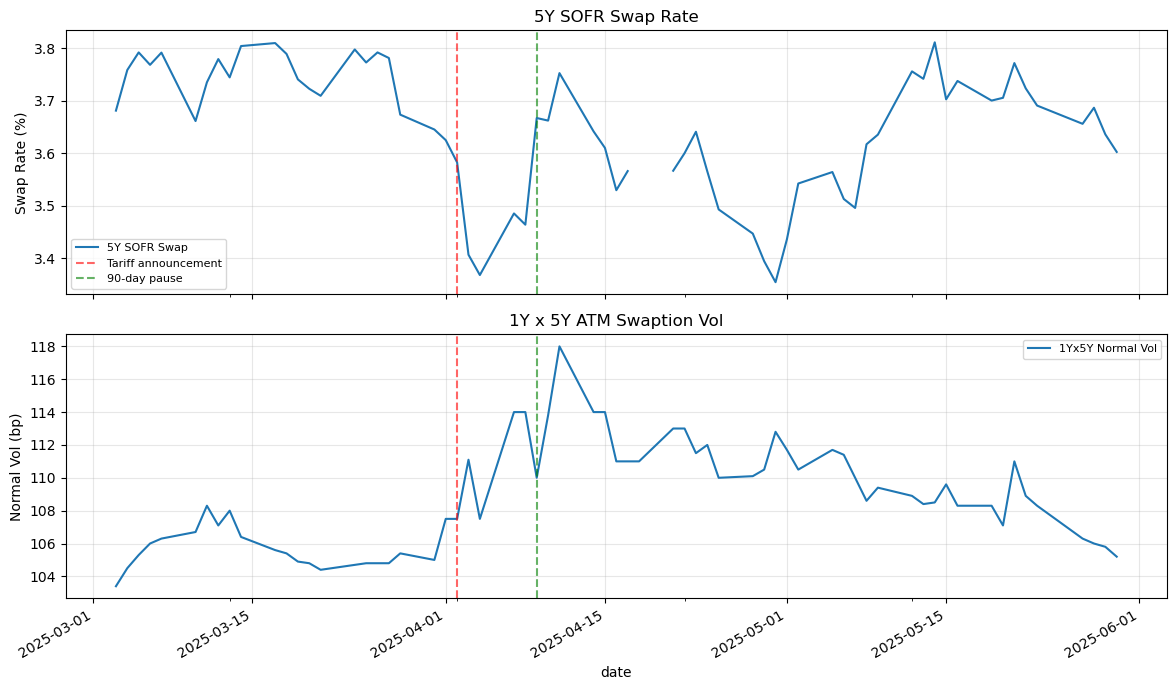

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1 = axes[0]
(rate_5y * 100).plot(ax=ax1, label='5Y SOFR Swap')
ax1.axvline(pd.Timestamp('2025-04-02'), color='red', linestyle='--', alpha=0.6, label='Tariff announcement')
ax1.axvline(pd.Timestamp('2025-04-09'), color='green', linestyle='--', alpha=0.6, label='90-day pause')
ax1.set_ylabel('Swap Rate (%)')
ax1.set_title('5Y SOFR Swap Rate')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
vol_1y5y.plot(ax=ax2, label='1Yx5Y Normal Vol')
ax2.axvline(pd.Timestamp('2025-04-02'), color='red', linestyle='--', alpha=0.6)
ax2.axvline(pd.Timestamp('2025-04-09'), color='green', linestyle='--', alpha=0.6)
ax2.set_ylabel('Normal Vol (bp)')
ax2.set_title('1Y x 5Y ATM Swaption Vol')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 1. SABR Calibration


### 1.1.

Extract the 1Y$\times$5Y swaption smile from the `April 1` daily data (pre-tariff). Report the market Black implied vols for each strike offset.


### 1.2.

Calibrate SABR with $\beta = 0.5$. Minimize the sum of squared vol errors over $(\nu, \rho)$, solving for $\alpha$ from the ATM constraint at each step.

Report the fitted parameters and overlay the model smile on the market data.


# 2. The Backbone


### 2.1.

Compute the SABR ATM vol as a function of the forward rate, holding all parameters fixed. Plot the backbone.


### 2.2.

Overlay the daily observations of $(F_t, \sigma_{\text{ATM},t})$ from `April 2025` on the backbone.

Convert the normal vol timeseries to approximate Black vol using $\sigma_B \approx \sigma_N / F$.


# 3. Augmented Delta


### 3.1.

Compute the Black delta and SABR augmented delta for the **OTM payer** ($K = F_0 + 100\text{bp}$) across a range of forward rates. Plot both, along with the correction.

$$\Delta_{\text{SABR}} = \Delta_{\text{Black}} + \mathcal{V}_{\text{Black}} \cdot \frac{\partial \sigma}{\partial F}$$

where $\frac{\partial \sigma}{\partial F}$ is computed by finite difference from the SABR formula.


### 3.2.

Decompose the correction into its components: $\partial\sigma/\partial F$, vega, and their product. Report at the current forward and at $\pm$50bp.


# 4. Smile Dynamics


### 4.1.

Using the daily smile data loaded above, calibrate SABR ($\beta = 0.5$) to each day's smile.
Report the fitted parameters ($\alpha, \nu, \rho$) over time. How stable are $\nu$ and $\rho$?


In [7]:
display(smile_daily.head(3).style.format('{:.2f}').set_caption(
    f'Daily Smile Data: first 3 of {len(smile_daily)} trading days (Black vol %)'))
display(fwd_daily.head(3).style.format('{:.2f}').set_caption(
    'ATM Forward Rates (%)'))


,-300,-200,-100,-50,-25,0,25,50,100,200,300
date,,,,,,,,,,,
2025-04-01 00:00:00,85.67,51.35,37.26,33.06,31.51,30.28,29.35,28.70,28.05,28.31,29.35
2025-04-02 00:00:00,90.32,52.76,37.92,33.50,31.85,30.55,29.55,28.85,28.13,28.33,29.36
2025-04-03 00:00:00,110.18,58.49,41.33,36.37,34.51,33.04,31.90,31.07,30.15,30.11,31.02


,atm_fwd_pct
date,
2025-04-01 00:00:00,3.57
2025-04-02 00:00:00,3.52
2025-04-03 00:00:00,3.35


### 4.2.

For each consecutive day, use the day-$t$ SABR backbone to predict the ATM vol at the day-$t{+}1$ forward rate. Compare to the actual next-day ATM vol.

Report the EOD vol, next-day vol, and SABR-predicted vol. How well does the backbone capture the vol dynamics?


### 4.3.

For the two key event days — `April 2→3` (tariff shock) and `April 8→9` (90-day pause) — test whether SABR correctly predicts the *shape* of the next-day smile.

At the same **absolute strikes** as day $t$:
* **Black** assumes the smile is unchanged.
* **SABR** uses the day-$t$ calibration ($\nu, \rho$), the actual day-$t{+}1$ ATM vol, and re-solves $\alpha$.

Plot all three curves (day $t$, SABR predicted, day $t{+}1$ actual). Report RMSE across all day-pairs.


# 5. Hedging Simulation (Extension)


### 5.1.

Using the `April` daily data, simulate a daily delta hedge of the OTM payer swaption ($K = F_0 + 100\text{bp}$) using the `April 1` calibration ($\nu, \rho$), re-solving $\alpha$ daily.

Plot the daily hedging error $\varepsilon_t = \Delta_{t-1} \cdot \Delta F_t - \Delta V_t$ for both Black and SABR delta. Report summary statistics.


### 5.2.

Repeat with an **ATM strike**. Compare the hedging error reduction at ATM vs OTM.
